Let's see if we can solve a differential equation using simulated annealing.


The idea is simple. Assume you have a differential equation of the form (the same arguments can be applied for PDEs)
$$
\dfrac{dy}{dt} =  G(t,y) 
$$
with an initial condition $y_0 = y(0)$, and a guess for $y(t)$ that depends on a number of free parameters. Denoting this guess as $\tilde{y}(t ; \{a\})$, find the values of $\{a\}$ tha minimize 

$$C(\{a\}) = \Big|y_0 - \tilde{y}(0,\{a\})\Big|+ \sum_i \Big| \dfrac{d\tilde{y}}{dt} -  G(t,\tilde{y}) \Big|_{t=t_i}  \;,$$
with $i$ running in a number of time points we wish to know the solution.

Since we would like to find a solution with $C \approx 0$, we can terminate the anealing process once $C < tol$. 

In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

In [2]:
class ODESimulatedAnnealing:
    def __init__(self, guess, rhs , dim, t, y0 , a0 ,  T0, k, IterationT, MinT, sigma, abs_tol):
        '''
        guess: a guess solution 
        rhs: the rhs of the differential equation
        dim: the number of paramters that parametrize the guess
        t:  the points where the solution is evaluated
        y0: initial condition
        
        a0: starting values for paramters
        k: to be used for the temperature update
        IterationT: number of iterations per temperature
        MinT:  stop when the temperature becomes MinT
        sigma: new neighbours are found between x+-sigma/2
        
        abs_tol: determine when to stop
        
        '''
        
        self.guess=guess
        self.rhs = rhs
        
        self.dim=dim
        self.a=a0
        
        self.T=T0
        self.k=k
        
        self.IterationT=IterationT
        self.MinT=MinT
        self.sigma=sigma
        
        self.abs_tol=abs_tol

        self.time = t
        self.y0 = y0
        self.N=float((1+len(t))*dim) #number of free parameters times thenumber of time points
        
        self.anew=self.a
        self.E=self.Cost()
        
    def nextT(self):
        '''Update the temperature'''
#         self.T=self.T/(1+k*self.T)
        self.T*=self.k
        
    def PickNeighbour(self):
        '''Pick a neighbour'''
#         self.xnew=self.x+np.random.rand(dim)*sigma-sigma/2
        self.anew=self.a+np.random.normal(self.sigma,size=self.dim)#the normal seems to work nicely. 
            
    
    def BoltzmannP(self,Enew):
        '''Given a new value of the energy, return the Boltzmann factor'''
        return np.exp(-(Enew-self.E)/self.T)
   
    def lhs(self,t,h=1e-5):
        '''The lhs of the differential equation'''
        h=h*t+h
        return (self.guess(t + h,self.anew) - self.guess(t - h,self.anew) )/(2*h)
    
        
    def Cost(self):
        '''
        The cost function
        defined as the squared error over the number of a times the number of time steps
        '''
        return  ((self.y0- self.guess(t[0],self.anew) )**2 + np.sum(  ( self.lhs(t)-self.rhs(t,self.anew) )**2 ))/(self.N)

    def Tinit(self):
        '''initialize T=Cost() if  T0=0'''
        self.T=self.Cost()
    
    def runT(self):
        for _ in range(self.IterationT):
            self.PickNeighbour()
            Enew=self.Cost()
            if Enew<self.E:
                self.E=Enew
                self.a=self.anew
            else:
                if self.BoltzmannP(Enew) > np.random.rand() :
                    self.E=Enew
                    self.a=self.anew
                
    def Solve(self):
        '''Iterate until the temperature reaches MinT'''
        if self.T==0:
            self.Tinit()
            
        while self.T>self.MinT and self.E>self.abs_tol:
            self.runT()

#             print(self.E)
            self.nextT()

        return self.a,self.E
    
        

Let's see how it works for 
$$
\dfrac{dy(t)}{dt}= c \, y(t)
$$

with a guess

$$
\tilde{y}(t,\{a\}) = a_1 e^{a_2 \, t}
$$


Keep in mind that exact solution of this is

$$
y(t)= y_0 \ e^{c \ t} \;.
$$



Practically, this kind of solution is very inefficient for simple ODEs. Perhaps  for larger systems of even for PDEs it can be better.


In [3]:
def guess(t,a):
    return a[0]*np.exp(a[1]*t)

def rhs(t,a):
    return guess(t,a)*3.2




In [4]:
y0=5

t=np.linspace(0,1,100)

In [5]:
dim=2
a0=[0,-2]

T0=0
k=0.99
IterationT=50
MinT=1e-200
sigma=0.5
abs_tol=1e-5

SA=ODESimulatedAnnealing(guess, rhs , dim, t, y0 , a0 ,  T0, k, IterationT, MinT, sigma, abs_tol )

SA.Solve()

(array([4.99935658, 3.19991325]), 8.938004869723555e-06)

<IPython.core.display.Javascript object>


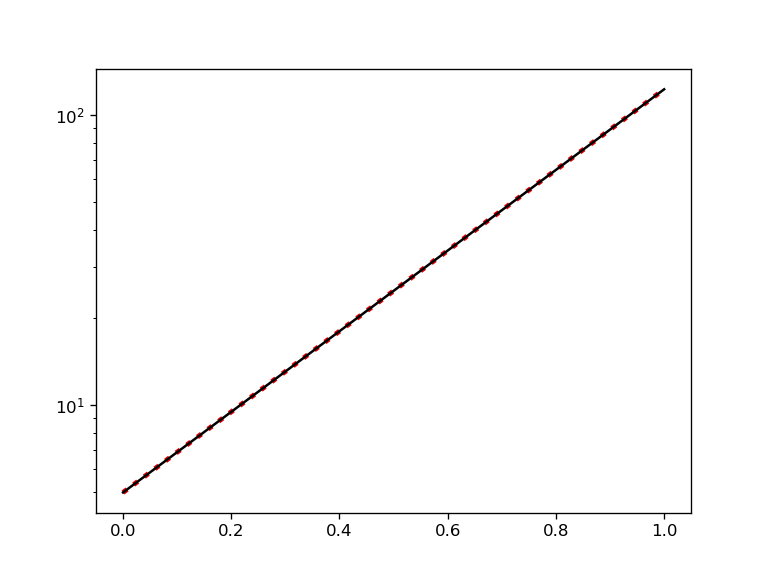

In [6]:
plt.plot(t,guess(t,SA.a),linestyle=':',linewidth=3,c='xkcd:red')
plt.plot(t,  y0*np.exp(3.2*t),c='xkcd:black' )

plt.yscale('log')

plt.show()